In [30]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
df = pd.read_csv("data-github/merged_m_i.csv")

In [31]:
df.shape

(26449, 12)

In [32]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Using device: cpu
Starting GAN training...
Epoch [0/15000] | D Loss: 0.6811 | G Loss: 0.6956
Epoch [1000/15000] | D Loss: 0.6444 | G Loss: 0.9519
Epoch [2000/15000] | D Loss: 0.6532 | G Loss: 1.0565
Epoch [3000/15000] | D Loss: 0.6599 | G Loss: 0.8436
Epoch [4000/15000] | D Loss: 0.6736 | G Loss: 0.8563
Epoch [5000/15000] | D Loss: 0.6757 | G Loss: 0.7628
Epoch [6000/15000] | D Loss: 0.6621 | G Loss: 0.7343
Epoch [7000/15000] | D Loss: 0.6687 | G Loss: 0.7324
Epoch [8000/15000] | D Loss: 0.6986 | G Loss: 0.7371
Epoch [9000/15000] | D Loss: 0.6885 | G Loss: 0.7167
Epoch [10000/15000] | D Loss: 0.6980 | G Loss: 0.6990
Epoch [11000/15000] | D Loss: 0.6810 | G Loss: 0.7293
Epoch [12000/15000] | D Loss: 0.6829 | G Loss: 0.7074
Epoch [13000/15000] | D Loss: 0.7002 | G Loss: 0.6948
Epoch [14000/15000] | D Loss: 0.6894 | G Loss: 0.6985


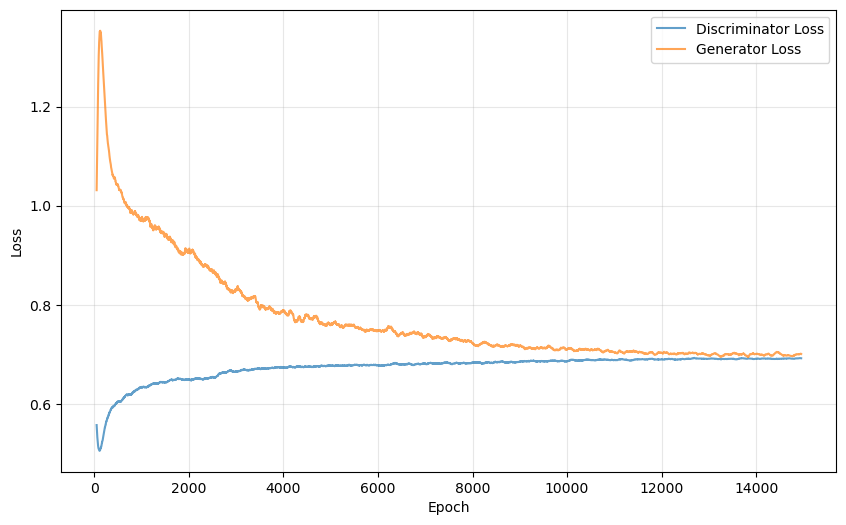

In [38]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Improved hyperparameters
noise_dim = 100  # Increased noise dimension
input_dim = 1    # Only 'throughput'
hidden_dim = 128 # Increased hidden dimension
lr_g = 0.0001    # Different learning rates
lr_d = 0.0004    # Discriminator learns faster
batch_size = 64  # Larger batch size for stability

# Improved Generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim),
            
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim // 2),
            
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim // 4),
            
            nn.Linear(hidden_dim // 4, input_dim),
            nn.Tanh()  # Output between -1 and 1
        )
    
    def forward(self, z):
        return self.model(z)

# Improved Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim // 4),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Linear(hidden_dim // 4, hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

# Initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss and optimizers with different learning rates
criterion = nn.BCELoss()
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))

# Improved training function
def train(real_data, epochs=10000, batch_size=64):
    # Scale data to [-1, 1] range for Tanh activation
    scaler = MinMaxScaler(feature_range=(-1, 1))
    real_data = scaler.fit_transform(real_data.reshape(-1, 1))
    real_data = torch.tensor(real_data, dtype=torch.float32).to(device)
    
    d_losses = []
    g_losses = []
    
    for epoch in range(epochs):
        # Train discriminator multiple times
        for _ in range(1):  # You can increase this for better discriminator training
            idx = np.random.randint(0, real_data.size(0), batch_size)
            real_samples = real_data[idx]
            
            # Label smoothing
            real_labels = torch.ones((batch_size, 1), device=device) * 0.9  # Smooth real labels
            fake_labels = torch.zeros((batch_size, 1), device=device) + 0.1  # Smooth fake labels
            
            # Train on real data
            d_optimizer.zero_grad()
            real_preds = discriminator(real_samples)
            d_loss_real = criterion(real_preds, real_labels)
            
            # Train on fake data
            noise = torch.randn(batch_size, noise_dim, device=device)
            fake_samples = generator(noise)
            fake_preds = discriminator(fake_samples.detach())
            d_loss_fake = criterion(fake_preds, fake_labels)
            
            # Combined discriminator loss
            d_loss = (d_loss_real + d_loss_fake) / 2
            d_loss.backward()
            d_optimizer.step()
        
        # Train generator
        g_optimizer.zero_grad()
        noise = torch.randn(batch_size, noise_dim, device=device)
        fake_samples = generator(noise)
        fake_preds = discriminator(fake_samples)
        g_loss = criterion(fake_preds, real_labels)  # Generator wants discriminator to think fake is real
        g_loss.backward()
        g_optimizer.step()
        
        # Store losses
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        
        # Print progress
        if epoch % 1000 == 0:
            print(f"Epoch [{epoch}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")
    
    return d_losses, g_losses, scaler

# Plot losses with smoothing
def plot_losses(d_losses, g_losses, save_path='gan_losses.png', window=100):
    plt.figure(figsize=(10, 6))
    
    # Apply moving average for smoother visualization
    def moving_average(data, window):
        return np.convolve(data, np.ones(window), 'valid') / window
    
    if len(d_losses) > window:
        d_losses_smooth = moving_average(d_losses, window)
        g_losses_smooth = moving_average(g_losses, window)
        x_smooth = range(window//2, len(d_losses) - window//2 + 1)
    else:
        d_losses_smooth = d_losses
        g_losses_smooth = g_losses
        x_smooth = range(len(d_losses))
    
    plt.plot(x_smooth, d_losses_smooth, label='Discriminator Loss', alpha=0.7)
    plt.plot(x_smooth, g_losses_smooth, label='Generator Loss', alpha=0.7)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    # plt.title('GAN Training Losses (Smoothed)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Generate synthetic data
def generate_synthetic_data(generator, scaler, n_samples=100):
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(n_samples, noise_dim, device=device)
        synthetic_scaled = generator(noise).cpu().numpy()
        synthetic_original = scaler.inverse_transform(synthetic_scaled)
    return synthetic_original

# Main training process
if __name__ == "__main__":
    # Create sample data
    np.random.seed(42)
    #df = pd.DataFrame({'DL_bitrate': np.random.normal(50, 15, 1000)})
    
    # Train the GAN
    print("Starting GAN training...")
    d_losses, g_losses, scaler = train(df[['DL_bitrate']].values, epochs=15000, batch_size=batch_size)
    
    # Plot losses
    plot_losses(d_losses, g_losses)
    
    # Generate synthetic data
    synthetic_data = generate_synthetic_data(generator, scaler, df.shape[0]) # produce df.shape[0] samples

In [34]:
fake_data = synthetic_data
real_data = df['DL_bitrate'].values.reshape(-1, 1)

In [35]:
fake_data.shape, real_data.shape

((26449, 1), (26449, 1))

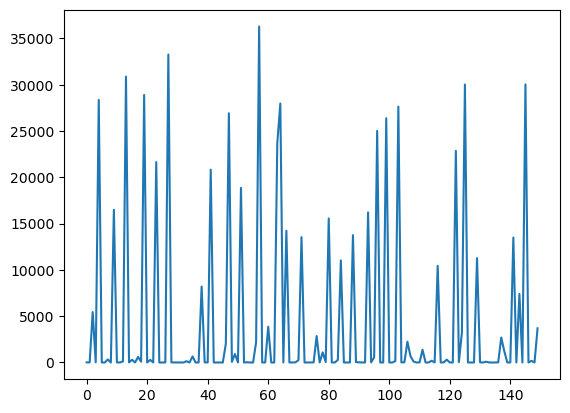

In [48]:
plt.plot(fake_data[400:550])
# plt.plot(real_data[400:550])

In [37]:
import numpy as np
from scipy.stats import ks_2samp, wasserstein_distance, entropy
import matplotlib.pyplot as plt

real_data_flat = real_data.flatten()
fake_data_flat = fake_data.flatten()

# Kolmogorov–Smirnov (KS) Test - needs 1D arrays
ks_stat, ks_p = ks_2samp(real_data_flat, fake_data_flat)

# Jensen–Shannon Divergence (binned)
def compute_js_divergence(p, q, bins=100):
    p_hist, bin_edges = np.histogram(p, bins=bins, density=True)
    q_hist, _ = np.histogram(q, bins=bin_edges, density=True)  # Fixed: use bin_edges, not bin*edges
    # Avoid division by zero
    p_hist += 1e-8
    q_hist += 1e-8
    m = 0.5 * (p_hist + q_hist)
    js_div = 0.5 * (entropy(p_hist, m) + entropy(q_hist, m))
    return js_div

js_divergence = compute_js_divergence(real_data_flat, fake_data_flat)

# Print results
print("Statistical Similarity Metrics")
print(f"KS Statistic         : {ks_stat:.4f} (p = {ks_p:.4f})")
print(f"Jensen–Shannon Divergence : {js_divergence:.4f}")

Statistical Similarity Metrics
KS Statistic         : 0.3184 (p = 0.0000)
Jensen–Shannon Divergence : 0.0260


In [ ]:
# Done